### Note: This notebook is meant to run on Google Colab

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import pickle
import numpy as np
from google.colab import files

import time
import json

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [3]:
pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [6]:
import segmentation_models_pytorch as smp

## Download the data from web

In [5]:
%pwd
%mkdir adl_data

In [6]:
%cd adl_data
%pwd

/content/adl_data


'/content/adl_data'

In [7]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2024-04-04 08:25:19--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-04-04 08:25:19--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-04-04 08:25:19--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [ ]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

In [9]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz


In [ ]:
%cd /content/adl_data/annotations/trimaps
!find . -type f -name '._*.png' -print
!find . -type f -name '._*.png' -exec rm {} +

%cd /content/adl_data/images
!find . -type f -name '*.mat' -print
!find . -type f -name '*.mat' -exec rm {} +


## Download the backbone model

In [11]:
# Download simclr_backbone from my googld drive
%cd /content/
# Cifar pretrain ResNet50 backbone
! gdown --id 1n4O_5rCcKv_UxSrSELV670fxsy3aLLgP

# Cat & dog pretrain ResNet50 backbone
! gdown --id 1wGZIR7hEaIT1DtxockGfEknZx0exXmS_

/content
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1n4O_5rCcKv_UxSrSELV670fxsy3aLLgP
From (redirected): https://drive.google.com/uc?id=1n4O_5rCcKv_UxSrSELV670fxsy3aLLgP&confirm=t&uuid=5b93cba9-4f4d-4a5c-9a71-57ba1d8ff7b7
To: /content/simclr_backbone.ckpt
100% 94.4M/94.4M [00:00<00:00, 152MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wGZIR7hEaIT1DtxockGfEknZx0exXmS_
From (redirected): https://drive.google.com/uc?id=1wGZIR7hEaIT1DtxockGfEknZx0exXmS_&confirm=t&uuid=c70381c6-8797-4adc-aa59-2375ee1d7770
To: /content/simclr

## Dataloader

In [7]:
import numpy as np
import random

seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# CUDA randomness
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [8]:

from torch.utils.data import Subset

def create_split_indices(dataset_size, test_split=0.2, random_seed=42):
    # Setting the random seed for reproducibility
    torch.manual_seed(random_seed)

    # Generating shuffled indices
    indices = torch.randperm(dataset_size).tolist()

    # Calculating the split index
    split = int(len(indices) * (1 - test_split))

    # Splitting the indices
    train_indices, test_indices = indices[:split], indices[split:]

    return train_indices, test_indices

def get_dataset_subsets(dataset, train_indices, test_indices):
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)
    return train_subset, test_subset


def save_indices(filename, indices, download = False):
  # Open a file in write mode ('w') and use a context manager
  with open(filename, 'w') as f:
      for index in indices:
          # Write each index to the file, followed by a newline character
          f.write(f"{index}\n")

  print(f'{filename} is saved.')

  if download:
    files.download(filename)

def load_indices(filename):
    # Open the file in read mode ('r') and use a context manager
  with open(filename, 'r') as f:
      # Read the lines, convert each line back to an integer, and remove newline characters
      loaded_indices = [int(line.strip()) for line in f]
  print(f'{filename} is loaded.')
  return loaded_indices



In [9]:
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform if mask_transform is not None else transform

        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)

    def preprocess_mask(self, mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0 # Background
        # mask[(mask == 1.0)] = 0.5 # Item
        mask[(mask == 3.0) | (mask == 1.0)] = 1.0 # Edge
        return mask

    # It defines how an item from the dataset is fetched given its index
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        trimap = np.array(Image.open(mask_path))
        mask = self.preprocess_mask(trimap)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = OxfordPetsDataset(images_dir='/content/adl_data/images', masks_dir='/content/adl_data/annotations/trimaps', transform=transform, mask_transform=mask_transform)

# Create split indices
dev_indices, test_indices = create_split_indices(len(dataset), test_split=0.2, random_seed=42)
# Create dataset subsets
dev_set, test_set = get_dataset_subsets(dataset, dev_indices, test_indices)

# Create split indices
train_indices, val_indices = create_split_indices(len(dev_indices), test_split=0.1, random_seed=42)
# Create dataset subsets
train_set, val_set = get_dataset_subsets(dev_set, train_indices, val_indices)

save_indices('/content/train_indices.txt', train_indices, True)
save_indices('/content/val_indices.txt', val_indices, True)
save_indices('/content/test_indices.txt', test_indices, True)

# dev_set, test_set = random_split(dataset, [0.8, 0.2])
# train_set, val_set = random_split(dev_set, [0.9, 0.1])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)


print(len(train_set), len(test_set), len(val_set), len(dataset))


/content/train_indices.txt is saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/val_indices.txt is saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/test_indices.txt is saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5320 1478 592 7390


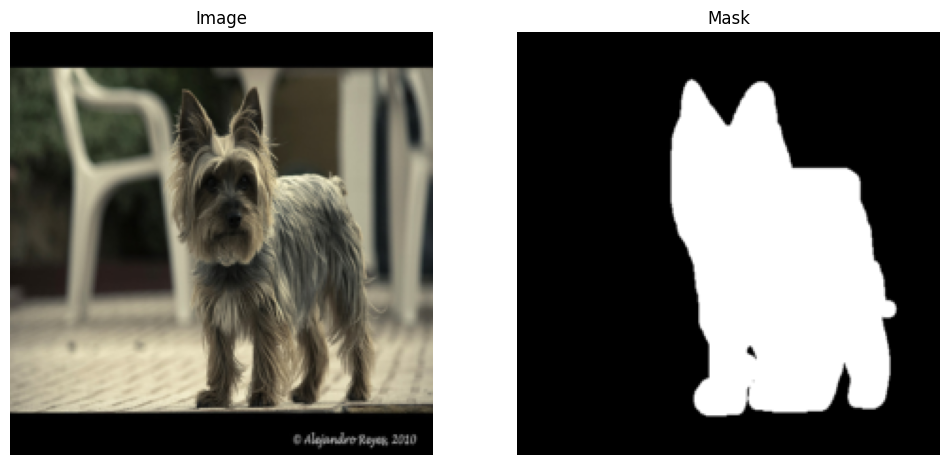

In [10]:
# Inspect dataset
image, mask = dataset[7389]

# Rearrange the dimensions
# from (channels, height, width) to (height, width, channels)
image_np = image.numpy().transpose(1, 2, 0)

# Normalize the image array to [0, 1] for visualization
# This reverses the normalization applied during the transform
image_np = (image_np * [0.5, 0.5, 0.5]) + [0.5, 0.5, 0.5]
image_np = np.clip(image_np, 0, 1)  # clip to the range [0, 1] for valid image values

# Convert the mask tensor to a numpy array for visualization
# Since the mask is a single-channel image, we use squeeze to remove the channel dimension for plotting
mask_np = mask.numpy().squeeze()

# Visualize the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')

# Visualize the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()


In [ ]:

# SEGMENTATION HEAD V1: FULLY-CONVOLUTED HEAD

from torchvision.models import resnet50

class SegmentationHead(nn.Module):
    def __init__(self, in_channels=2048, out_channels=1, feature_size=(224, 224)):
        super(SegmentationHead, self).__init__()
        # Assuming we want to output a single-channel binary segmentation map
        self.upsample = nn.Upsample(size=feature_size, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(512, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        # No activation here, assuming the use of BCEWithLogitsLoss which combines sigmoid
        return x


class ResNetSegmentation(nn.Module):
    def __init__(self, backbone, segmentation_head):
        super(ResNetSegmentation, self).__init__()
        self.backbone = backbone
        self.segmentation_head = segmentation_head

    def forward(self, x):
        for param in self.backbone.parameters():
          param.requires_grad = False
        # Pass input through ResNet backbone
        features = self.backbone(x)
        # Pass backbone features through segmentation head
        segmentation_output = self.segmentation_head(features)
        return segmentation_output

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# Initialize ResNet backbone
backbone = resnet50(pretrained=False)

# Load the pre-trained weights
backbone.load_state_dict(torch.load("/content/simclr_backbone_19.ckpt", map_location=torch.device(device)), strict=False)

# Remove avgpool and fc, try the below code to see the original architecture
# print(list(backbone.children()))
backbone = nn.Sequential(*(list(backbone.children())[:-2]))

for param in backbone.parameters():
    param.requires_grad = False

# Initialize segmentation head
segmentation_head = SegmentationHead(in_channels=2048, out_channels=1, feature_size=(224, 224))

# Combine into a full model
model = ResNetSegmentation(backbone=backbone, segmentation_head=segmentation_head)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
# SEGMENTATION HEAD V2: UNET

import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",  # choose encoder, use `resnet50` for ResNet50
    encoder_weights=None,     # use `None` to not load the pre-trained weights
    in_channels=3,            # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,                # model output channels (number of classes in your dataset)
)

# Load the weights into the model
model.load_state_dict(torch.load("/content/simclr_backbone.ckpt", map_location=torch.device(device)), strict=False)

# Freeze encoder (pre-trained backbone) weights
for param in model.encoder.parameters():
  param.requires_grad = False



In [11]:
# Baseline model

model = smp.Unet(
    encoder_name="resnet50",  # choose encoder, use `resnet50` for ResNet50
    encoder_weights=None,     # use `None` to not load the pre-trained weights
    in_channels=3,            # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,                # model output channels (number of classes in your dataset)
)

In [ ]:
def print_requires_grad_status(model):
    for name, param in model.named_parameters():
        print(f"{name} requires_grad: {param.requires_grad}")

print_requires_grad_status(model)


In [13]:
def train_segmentation_model(model, train_loader, val_loader, num_epochs=10, loss_type='Dice', learning_rate=1e-4, device='cpu', model_name = 'model'):
    start_time = time.time()
    # Set the model to training mode and move it to the specified device
    model.train()
    model.to(device)

    # Define the optimizer - only parameters with requires_grad=True will be updated
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


    # Define the loss function
    if loss_type == 'Dice':
      criterion = smp.losses.DiceLoss(mode = 'binary')
    elif loss_type == 'Focal':
      criterion = smp.losses.FocalLoss(mode = 'binary')
    else:
      # Binary Cross Entropy Loss With Sigmoid Function
      criterion = nn.BCEWithLogitsLoss()

    # Monitor loss in validation set
    dice_loss_fn = smp.losses.DiceLoss(mode='binary')
    focal_loss_fn = smp.losses.FocalLoss(mode='binary')
    bce_loss_fn = nn.BCEWithLogitsLoss()

    # List to store loss values per batch
    batch_loss_list = []
    iou_scores_list, f1_scores_micro_list, f1_scores_macro_list, dice_loss_list, focal_loss_list, bce_loss_list = [], [], [], [], [], []

    for epoch in range(num_epochs):
        running_loss_batch = 0.0
        running_loss = 0.0

        batch_loss_values = []

        for i, (images, masks) in enumerate(train_loader):
            images = images.to(device)

            # Ensure masks are LongTensor and on the correct device
            masks = masks.float().to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute loss per every batch and cummulative loss
            running_loss_batch += loss.item()
            running_loss += loss.item()

            batch_loss_values.append(loss.item())

            if (i+1) % 10 == 0 :    # Print every 10 mini-batches
                print(f'[%d, %5d] {loss_type} loss: %.3f' %
                    (epoch + 1, i + 1, running_loss_batch / 10))
                running_loss_batch = 0

        train_loss = running_loss / (len(train_loader) * train_loader.batch_size) # Total loss / total number of training data
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}')
        batch_loss_list.append(batch_loss_values)

        if (epoch + 1)%10 ==0:
          # Example of saving a checkpoint after 10 epoch
          torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': batch_loss_values[-1],  # Last batch loss of the epoch
            }, f'/content/checkpoint_epoch_{epoch+1}.pth')


        if (epoch + 1)%2 ==0:
          model.eval()
          iou_scores, f1_scores_micro, f1_scores_macro, dice_loss, focal_loss, bce_loss = [], [], [], [], [], []

          with torch.no_grad():
              # Compute metrics on every batch
              for images, masks in val_loader:
                  images, masks = images.to(device), masks.float().to(device)
                  outputs = model(images)

                  # Compute SMP metrics
                  tp, fp, fn, tn = smp.metrics.get_stats(masks.long(), outputs.long(), mode='binary', threshold=0.5)

                  # For 'binary' case 'micro' = 'macro' = 'weighted'
                  iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
                  f1_score_micro = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
                  f1_score_macro = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")

                  iou_scores.append(iou_score.item())
                  f1_scores_micro.append(f1_score_micro.item())
                  f1_scores_macro.append(f1_score_macro.item())
                  dice_loss.append(dice_loss_fn(outputs, masks).item())
                  focal_loss.append(focal_loss_fn(outputs, masks).item())
                  bce_loss.append(bce_loss_fn(outputs, masks).item())

          mean_iou = np.mean(iou_scores)
          mean_fscore_micro = np.mean(f1_scores_micro)
          mean_fscore_macro = np.mean(f1_scores_macro)
          mean_dice = np.mean(dice_loss)
          mean_focal = np.mean(focal_loss)
          mean_bce = np.mean(bce_loss)

          print(f'Validation (Epoch {epoch + 1}) - IoU: {mean_iou:.4f}, F1-score-micro: {mean_fscore_micro:.4f}, F1-score-macro: {mean_fscore_macro:.4f}, Dice-loss: {mean_dice:.4f}, Focal-loss: {mean_focal:.4f}, BCE-loss: {mean_bce:.4f}')

          iou_scores_list.append(mean_iou)
          f1_scores_micro_list.append(mean_fscore_micro)
          f1_scores_macro_list.append(mean_fscore_macro)
          dice_loss_list.append(mean_dice)
          focal_loss_list.append(mean_focal)
          bce_loss_list.append(mean_bce)

    # Save the final model
    torch.save(model.state_dict(), f'/content/{model_name}.pth')

    # Automatically prompt the browser to download the file to your local machine
    files.download(f'/content/{model_name}.pth')
    print(f'Total training time: {time.time()-start_time:4f}s')

    metrics = {'batch_loss': batch_loss_list,
               'iou': iou_scores_list,
               'f1_micro': f1_scores_micro_list,
               'f1_macro': f1_scores_macro_list,
               'dice': dice_loss_list,
               'focal': focal_loss_list,
               'BCE': bce_loss_list}

    return model, metrics

# Call the training function
model, metrics = train_segmentation_model(model, train_loader, val_loader, num_epochs=60, loss_type='Dice', learning_rate=1e-4, device=device, model_name = 'baseline_model_dice')


[1,    10] Dice loss: 0.457
[1,    20] Dice loss: 0.395
[1,    30] Dice loss: 0.362
[1,    40] Dice loss: 0.344
[1,    50] Dice loss: 0.338
[1,    60] Dice loss: 0.311
[1,    70] Dice loss: 0.298
[1,    80] Dice loss: 0.283
Epoch [1/60], Loss: 0.005415314121083135
[2,    10] Dice loss: 0.279
[2,    20] Dice loss: 0.279
[2,    30] Dice loss: 0.266
[2,    40] Dice loss: 0.265
[2,    50] Dice loss: 0.254
[2,    60] Dice loss: 0.258
[2,    70] Dice loss: 0.242
[2,    80] Dice loss: 0.245
Epoch [2/60], Loss: 0.004070490554329895
Validation (Epoch 2) - IoU: 0.6517, F1-score-micro: 0.7887, F1-score-macro: 0.7887, Dice-loss: 0.2478, Focal-loss: 0.4892, BCE-loss: 0.6350
[3,    10] Dice loss: 0.338
[3,    20] Dice loss: 0.361
[3,    30] Dice loss: 0.270
[3,    40] Dice loss: 0.240
[3,    50] Dice loss: 0.231
[3,    60] Dice loss: 0.227
[3,    70] Dice loss: 0.214
[3,    80] Dice loss: 0.216
Epoch [3/60], Loss: 0.004069332221877717
[4,    10] Dice loss: 0.217
[4,    20] Dice loss: 0.205
[4,    30

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total training time: 4022.583375s


In [15]:
for key, value in metrics.items():
  print(key, len(value))

filename = '/content/baseline_dice.json'

# Writing the dictionary to a file in JSON format
with open(filename, 'w') as f:
    json.dump(metrics, f)

files.download(filename)

batch_loss 60
iou 30
f1_micro 30
f1_macro 30
dice 30
focal 30
BCE 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

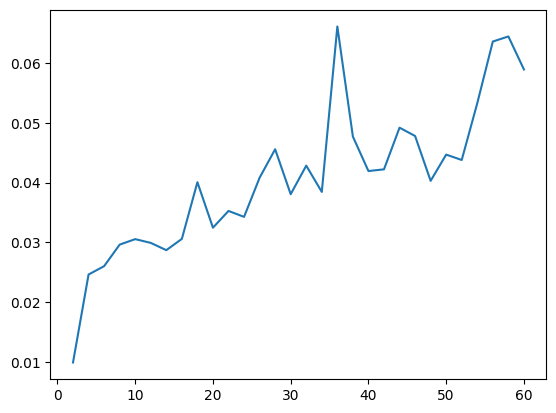

In [18]:
 import matplotlib.pyplot as plt
 plt.plot(np.arange(2, 62, 2), np.array(metrics['BCE'])/64)

In [ ]:
# Load models or checkpoints

# model = ResNetSegmentation(backbone=backbone, segmentation_head=segmentation_head)
# checkpoint = torch.load('/content/checkpoint_epoch_20.pth')
# # model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load("/content/final_model_new.pth", map_location=torch.device(device)), strict=False)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model.eval()


In [11]:
%cd /content/
# Cat & dog Unet model
! gdown --id 1U4vXy5LI-ZS7-C6vWZdweYe7OE8dC9u5

# Cifar Unet model
! gdown --id 1_c0aC_9wHjCH4EguoTpK54PMJmrwQbxQ

/content
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1U4vXy5LI-ZS7-C6vWZdweYe7OE8dC9u5
From (redirected): https://drive.google.com/uc?id=1U4vXy5LI-ZS7-C6vWZdweYe7OE8dC9u5&confirm=t&uuid=624ab542-dfeb-4552-ae03-9015ca299056
To: /content/cat_dog_unet.pth
100% 130M/130M [00:00<00:00, 167MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1_c0aC_9wHjCH4EguoTpK54PMJmrwQbxQ
From (redirected): https://drive.google.com/uc?id=1_c0aC_9wHjCH4EguoTpK54PMJmrwQbxQ&confirm=t&uuid=daedc5a1-3f85-4fcf-9da6-699de574f6f0
To: /content/cifar_unet.p

In [40]:

def visual_inspection(model, testset, inspect_num = 1):
  # Inspect performance

  test_img, test_mask = testset[inspect_num] #next(iter(test_loader))

  img, mask = test_img.to(device), test_mask.to(device)

  pred_mask = model(img.reshape(-1, 3, 224, 224))

  # Convert predictions to probability using sigmoid
  pred_prob = torch.sigmoid(pred_mask)
  # Convert probabilities to binary mask (e.g., threshold at 0.5)
  pred_binary_mask = (pred_prob > 0.5).float()

  # Move tensors to CPU for plotting
  img_cpu = img.squeeze().cpu().detach()
  mask_cpu = mask.squeeze().cpu().detach()
  pred_binary_mask_cpu = pred_binary_mask.squeeze().cpu().detach()

  # Normalize img for displaying purposes
  img_display = img_cpu.permute(1, 2, 0)
  img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

  # Plotting
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 3, 1)
  plt.imshow(img_display)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(mask_cpu, cmap='gray')
  plt.title('Ground Truth Mask')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(pred_binary_mask_cpu, cmap='gray')
  plt.title('Predicted Mask')
  plt.axis('off')

  plt.show()


def evaluate_model(model, test_loader, device, message):
  print(f'Evaluate: {message}')
  model.eval()

  # Monitor loss in validation set
  dice_loss_fn = smp.losses.DiceLoss(mode='binary')
  focal_loss_fn = smp.losses.FocalLoss(mode='binary')
  bce_loss_fn = nn.BCEWithLogitsLoss()
  iou_scores, f1_scores_micro, f1_scores_macro, dice_loss, focal_loss, bce_loss = [], [], [], [], [], []

  with torch.no_grad():
      for images, masks in val_loader:
          images, masks = images.to(device), masks.float().to(device)
          outputs = model(images)

          # Compute SMP metrics
          tp, fp, fn, tn = smp.metrics.get_stats(masks.long(), outputs.long(), mode='binary', threshold=0.5)

          # For 'binary' case 'micro' = 'macro' = 'weighted'
          iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
          f1_score_micro = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
          f1_score_macro = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")

          iou_scores.append(iou_score.item())
          f1_scores_micro.append(f1_score_micro.item())
          f1_scores_macro.append(f1_score_macro.item())
          dice_loss.append(dice_loss_fn(outputs, masks).item())
          focal_loss.append(focal_loss_fn(outputs, masks).item())
          bce_loss.append(bce_loss_fn(outputs, masks).item())

  mean_iou = np.mean(iou_scores)
  mean_fscore_micro = np.mean(f1_scores_micro)
  mean_fscore_macro = np.mean(f1_scores_macro)
  mean_dice = np.mean(dice_loss)
  mean_focal = np.mean(focal_loss)
  mean_bce = np.mean(bce_loss)

  inspect_num = 15 #np.random.randint(0, test_loader.batch_size)

  visual_inspection(model, test_loader.dataset, inspect_num)

  print(f'Testing - IoU: {mean_iou:.4f}, F1-score-micro: {mean_fscore_micro:.4f}, F1-score-macro: {mean_fscore_macro:.4f}, Dice-loss: {mean_dice:.4f}, Focal-loss: {mean_focal:.4f}, BCE-loss: {mean_bce:.4f}')
  print(' ')
  return (mean_iou, mean_fscore_micro, mean_fscore_macro, mean_dice, mean_focal, mean_bce)



Evaluate: Baseline Model BCE


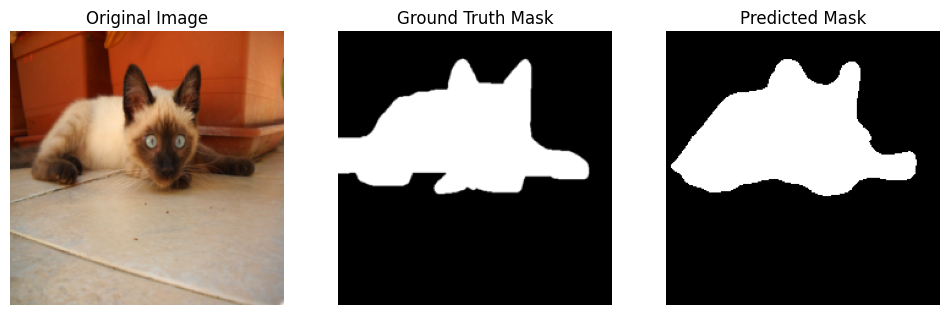

Testing - IoU: 0.8012, F1-score-micro: 0.8895, F1-score-macro: 0.8895, Dice-loss: 0.1155, Focal-loss: 0.3715, BCE-loss: 0.4195
 
Evaluate: Baseline Model Dice


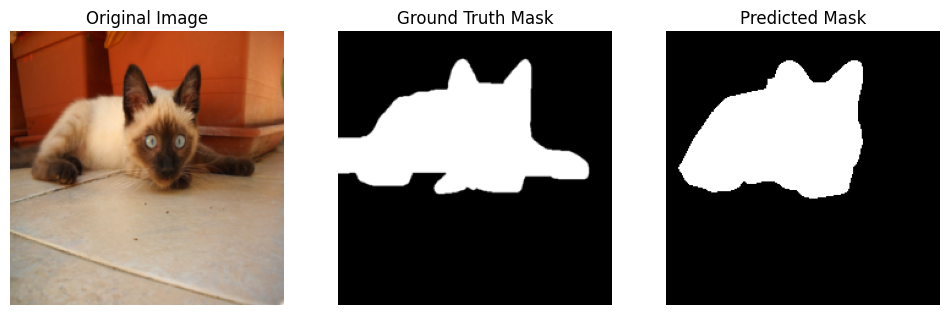

Testing - IoU: 0.7958, F1-score-micro: 0.8861, F1-score-macro: 0.8861, Dice-loss: 0.1110, Focal-loss: 3.6432, BCE-loss: 3.6490
 


In [41]:
model_1 = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1.load_state_dict(torch.load("/content/baseline_model_BCE.pth", map_location=torch.device(device)), strict=False)

model_1.to(device)
model_1.eval()

res1 = evaluate_model(model_1, test_loader, device, message = 'Baseline Model BCE')

model_2 = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)

model_2.load_state_dict(torch.load("/content/baseline_model_dice.pth", map_location=torch.device(device)), strict=False)
model_2.to(device)
model_2.eval()

res2 = evaluate_model(model_2, test_loader, device, message = 'Baseline Model Dice')

In [ ]:
# Clear RAM space for colab
import gc

del train_loader
del test_loader
del val_loader
del model

# Collect garbage
gc.collect()

# If using PyTorch and want to free up GPU memory:
torch.cuda.empty_cache()